<a href="https://colab.research.google.com/github/RicoStaedeli/NLP2025_CQG/blob/main/5_Evaluation_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up

In [1]:
from google.colab import userdata
import os

In [2]:
token = userdata.get('GITHUB')
repo_url = f"https://{token}@github.com/RicoStaedeli/NLP2025_CQG.git"

!git clone {repo_url}


os.chdir("NLP2025_CQG")
!ls

Cloning into 'NLP2025_CQG'...
remote: Enumerating objects: 1551, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 1551 (delta 157), reused 123 (delta 107), pack-reused 1352 (from 2)
Receiving objects: 100% (1551/1551), 55.04 MiB | 3.75 MiB/s, done.
Resolving deltas: 100% (887/887), done.
Updating files: 100% (87/87), done.
1_a_Generate_DPO_Dataset.ipynb	      Development
1_Information_preprocessing.md	      Doc
1_Preprocessing.ipynb		      Evaluation
2_Baseline_Generation.ipynb	      INFORMATION.md
2_Information_Baseline_Generation.md  LICENSE
3_Evaluation.ipynb		      Logs
4_Finetuned_Generation.ipynb	      README.md
5_Evaluation_Analytics.ipynb	      Training
Data


In [5]:
import json

baseline_file = "results_Meta-Llama-3.1-8B-Instruct_schema_prompt_eval"
sft_file = "results_Meta-Llama-3.1-1B-Instruct_SFT_2_schema_prompt_eval"
dpo_file = "results_Meta-Llama-3.1-8B-Instruct_DPO_schema_prompt_eval"
dpo_sft_file = "results_Meta-Llama-3.1-8B-Instruct_SFT_DPO_schema_prompt_1_eval"

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/{baseline_file}.json"), "r", encoding="utf-8") as f:
    baseline_data = json.load(f)

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/{sft_file}.json"), "r", encoding="utf-8") as f:
    sft_data = json.load(f)

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/{dpo_file}.json"), "r", encoding="utf-8") as f:
    dpo_data = json.load(f)

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/{dpo_sft_file}.json"), "r", encoding="utf-8") as f:
    dpo_sft_data = json.load(f)

raw_data = [baseline_data, sft_data, dpo_data, dpo_sft_data]

In [6]:
import pandas as pd

dfs = []
for data in raw_data:
  rows = []
  for entry_id, entry_data in data.items():
      context = entry_data['input']
      for cq in entry_data['cqs']:
          row = {
              "id": entry_id,
              "input": context,
              "schema": cq["schema"],
              "question": cq["cq"],
              "CauseToEffect": cq["CauseToEffect"],
              "ExpertOpinion": cq["ExpertOpinion"],
              "Analogy": cq["Analogy"],
              "FearAppeal": cq["FearAppeal"],
              "is_critical": cq["is_critical"],
              "passed_rules": cq["passed_rules"],
              "in_context": cq["in_context"]
          }
          rows.append(row)
  dfs.append(pd.DataFrame(rows))

model_names = ["Baseline", "SFT", "DPO", "DPO_SFT"]

## Analysis

1. baseline (index 0)
2. sft (index 1)
3. dpo (index 2)
4. dpo with sft (index 3)

In [7]:
summary = []

for i, df in enumerate(dfs):
    total = len(df)

    critical_count = df['is_critical'].sum()
    in_context_count = df['in_context'].sum()

    critical_and_in_context = df[(df['is_critical'] == True) & (df['in_context'] == True)]
    critical_and_in_context_count = len(critical_and_in_context)

    summary.append({
        'Model': model_names[i],
        'Total Entries': total,
        'Critical Count': critical_count,
        '% Critical': (critical_count / total) * 100,
        'In Context Count': in_context_count,
        '% In Context': (in_context_count / total) * 100,
        'Critical & In Context Count': critical_and_in_context_count,
        '% Critical & In Context': (critical_and_in_context_count / total) * 100
    })

summary_df = pd.DataFrame(summary)

styler = summary_df.style.background_gradient(cmap='Blues', subset=[
    '% Critical', '% In Context', '% Critical & In Context'
])
styler = styler.format({
    'Total Entries': '{:,}',
    'Critical Count': '{:,}',
    'In Context Count': '{:,}',
    'Critical & In Context Count': '{:,}',
    '% Critical': '{:.1f}%',
    '% In Context': '{:.1f}%',
    '% Critical & In Context': '{:.1f}%'
})

display(styler)

,Model,Total Entries,Critical Count,% Critical,In Context Count,% In Context,Critical & In Context Count,% Critical & In Context
0,Baseline,744,237,31.9%,472,63.4%,132,17.7%
1,SFT,744,486,65.3%,488,65.6%,281,37.8%
2,DPO,744,185,24.9%,536,72.0%,135,18.1%
3,DPO_SFT,744,235,31.6%,550,73.9%,173,23.3%


### Context & Rule check

### Core Analysis

In [8]:
for i, df in enumerate(dfs):
    df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

    critical_summary = (
        df.groupby('schema')['is_critical']
        .agg(Total='count', Critical='sum')
        .reset_index()
    )
    critical_summary['% Critical'] = (critical_summary['Critical'] / critical_summary['Total']) * 100

    score_stats = (
        df.groupby('schema')['schema_score']
        .agg(Average_Score='mean', Median_Score='median', Std_Dev='std', Min_Score='min', Max_Score='max')
        .reset_index()
    )

    in_context_counts = (
        df[df['in_context'] == True]
        .groupby('schema')
        .size()
        .reset_index(name='In_Context_Count')
    )

    in_context_critical_counts = (
        df[(df['in_context'] == True) & (df['is_critical'] == True)]
        .groupby('schema')
        .size()
        .reset_index(name='In_Context_Critical_Count')
    )

    combined_summary = critical_summary.merge(score_stats, on='schema', how='left')
    combined_summary = combined_summary.merge(in_context_counts, on='schema', how='left')
    combined_summary = combined_summary.merge(in_context_critical_counts, on='schema', how='left')

    combined_summary[['In_Context_Count', 'In_Context_Critical_Count']] = combined_summary[
        ['In_Context_Count', 'In_Context_Critical_Count']
    ].fillna(0).astype(int)

    combined_summary['% In Context'] = (combined_summary['In_Context_Count'] / combined_summary['Total']) * 100
    combined_summary['% In Context & Critical'] = (combined_summary['In_Context_Critical_Count'] / combined_summary['Total']) * 100

    combined_summary = combined_summary.sort_values(by='schema').reset_index(drop=True)

    pos_gradient_cols = ['% Critical', 'Average_Score', 'Median_Score', '% In Context', '% In Context & Critical']
    neg_gradient_cols = ['Std_Dev']

    styler = combined_summary.style
    styler = styler.background_gradient(cmap='Greens', subset=pos_gradient_cols)
    styler = styler.background_gradient(cmap='Reds_r', subset=neg_gradient_cols)
    styler = styler.format({
        'Average_Score': '{:.2f}',
        'Median_Score': '{:.2f}',
        'Std_Dev': '{:.2f}',
        '% Critical': '{:.1f}%',
        '% In Context': '{:.1f}%',
        '% In Context & Critical': '{:.1f}%'
    })
    name = ""
    if i == 0:
      name = "Baseline"
    elif i == 1:
      name = "SFT"
    elif i == 2:
      name = "DPO"
    else:
      name = "DPO_SFT"

    print(f"Summary Table for {name}")
    display(styler)


Summary Table for Baseline


,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score,In_Context_Count,In_Context_Critical_Count,% In Context,% In Context & Critical
0,Analogy,186,103,55.4%,6.69,7.25,1.87,4.000000,10.000000,108,56,58.1%,30.1%
1,CauseToEffect,186,38,20.4%,5.21,5.00,2.45,0.000000,10.000000,122,24,65.6%,12.9%
2,ExpertOpinion,186,82,44.1%,5.80,6.00,2.08,0.000000,10.000000,112,41,60.2%,22.0%
3,FearAppeal,186,14,7.5%,4.25,4.00,1.51,2.000000,10.000000,130,11,69.9%,5.9%


Summary Table for SFT


,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score,In_Context_Count,In_Context_Critical_Count,% In Context,% In Context & Critical
0,Analogy,186,99,53.2%,7.11,7.50,2.09,3.000000,10.000000,124,60,66.7%,32.3%
1,CauseToEffect,186,147,79.0%,7.81,8.00,1.65,0.000000,10.000000,109,81,58.6%,43.5%
2,ExpertOpinion,186,181,97.3%,8.72,9.00,1.03,2.000000,10.500000,115,113,61.8%,60.8%
3,FearAppeal,186,59,31.7%,5.49,5.00,2.42,2.000000,10.000000,140,27,75.3%,14.5%


Summary Table for DPO


,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score,In_Context_Count,In_Context_Critical_Count,% In Context,% In Context & Critical
0,Analogy,186,61,32.8%,5.73,5.00,1.81,3.000000,10.000000,131,45,70.4%,24.2%
1,CauseToEffect,186,42,22.6%,4.58,4.00,2.71,0.000000,10.000000,135,30,72.6%,16.1%
2,ExpertOpinion,186,71,38.2%,5.40,6.00,2.40,0.000000,10.000000,129,52,69.4%,28.0%
3,FearAppeal,186,11,5.9%,4.15,4.00,1.52,2.000000,10.000000,141,8,75.8%,4.3%


Summary Table for DPO_SFT


,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score,In_Context_Count,In_Context_Critical_Count,% In Context,% In Context & Critical
0,Analogy,186,67,36.0%,6.16,5.50,1.79,3.000000,10.000000,127,51,68.3%,27.4%
1,CauseToEffect,186,59,31.7%,5.17,5.00,2.92,0.000000,10.000000,146,46,78.5%,24.7%
2,ExpertOpinion,186,88,47.3%,6.08,6.00,2.38,0.000000,10.000000,134,61,72.0%,32.8%
3,FearAppeal,186,21,11.3%,4.45,4.00,1.71,2.000000,10.000000,143,15,76.9%,8.1%


In [9]:
all_summaries = []

for i, df in enumerate(dfs):
    df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

    critical_summary = (
        df.groupby('schema')['is_critical']
        .agg(Total='count', Critical='sum')
        .reset_index()
    )
    critical_summary['% Critical'] = (critical_summary['Critical'] / critical_summary['Total']) * 100

    score_stats = (
        df.groupby('schema')['schema_score']
        .agg(Average_Score='mean', Median_Score='median', Std_Dev='std', Min_Score='min', Max_Score='max')
        .reset_index()
    )

    in_context_counts = (
        df[df['in_context'] == True]
        .groupby('schema')
        .size()
        .reset_index(name='In_Context_Count')
    )

    in_context_critical_counts = (
        df[(df['in_context'] == True) & (df['is_critical'] == True)]
        .groupby('schema')
        .size()
        .reset_index(name='In_Context_Critical_Count')
    )

    combined = critical_summary.merge(score_stats, on='schema', how='left')
    combined = combined.merge(in_context_counts, on='schema', how='left')
    combined = combined.merge(in_context_critical_counts, on='schema', how='left')

    combined[['In_Context_Count', 'In_Context_Critical_Count']] = combined[
        ['In_Context_Count', 'In_Context_Critical_Count']
    ].fillna(0).astype(int)

    combined['% In Context'] = (combined['In_Context_Count'] / combined['Total']) * 100
    combined['% In Context & Critical'] = (combined['In_Context_Critical_Count'] / combined['Total']) * 100

    combined['Model'] = model_names[i]
    all_summaries.append(combined)

combined_all = pd.concat(all_summaries)

schemas = sorted(combined_all['schema'].unique())

metrics = ['Average_Score', 'Median_Score', 'Std_Dev', '% Critical', '% In Context', '% In Context & Critical']

for schema in schemas:
    schema_df = combined_all[combined_all['schema'] == schema].set_index('Model')[metrics]

    numeric_cols = schema_df.select_dtypes(include='number').columns
    percent_cols = [col for col in numeric_cols if '%' in col]
    float_cols = [col for col in numeric_cols if '%' not in col]

    styler = schema_df.style
    styler = styler.background_gradient(cmap='Greens', subset=numeric_cols)
    styler = styler.format('{:.2f}', subset=float_cols)
    styler = styler.format('{:.1f}%', subset=percent_cols)

    print(f"\n ### Schema: {schema}")
    display(styler)



 ### Schema: Analogy


,Average_Score,Median_Score,Std_Dev,% Critical,% In Context,% In Context & Critical
Model,,,,,,
Baseline,6.69,7.25,1.87,55.4%,58.1%,30.1%
SFT,7.11,7.50,2.09,53.2%,66.7%,32.3%
DPO,5.73,5.00,1.81,32.8%,70.4%,24.2%
DPO_SFT,6.16,5.50,1.79,36.0%,68.3%,27.4%



 ### Schema: CauseToEffect


,Average_Score,Median_Score,Std_Dev,% Critical,% In Context,% In Context & Critical
Model,,,,,,
Baseline,5.21,5.00,2.45,20.4%,65.6%,12.9%
SFT,7.81,8.00,1.65,79.0%,58.6%,43.5%
DPO,4.58,4.00,2.71,22.6%,72.6%,16.1%
DPO_SFT,5.17,5.00,2.92,31.7%,78.5%,24.7%



 ### Schema: ExpertOpinion


,Average_Score,Median_Score,Std_Dev,% Critical,% In Context,% In Context & Critical
Model,,,,,,
Baseline,5.80,6.00,2.08,44.1%,60.2%,22.0%
SFT,8.72,9.00,1.03,97.3%,61.8%,60.8%
DPO,5.40,6.00,2.40,38.2%,69.4%,28.0%
DPO_SFT,6.08,6.00,2.38,47.3%,72.0%,32.8%



 ### Schema: FearAppeal


,Average_Score,Median_Score,Std_Dev,% Critical,% In Context,% In Context & Critical
Model,,,,,,
Baseline,4.25,4.00,1.51,7.5%,69.9%,5.9%
SFT,5.49,5.00,2.42,31.7%,75.3%,14.5%
DPO,4.15,4.00,1.52,5.9%,75.8%,4.3%
DPO_SFT,4.45,4.00,1.71,11.3%,76.9%,8.1%


Score distribution over all questions

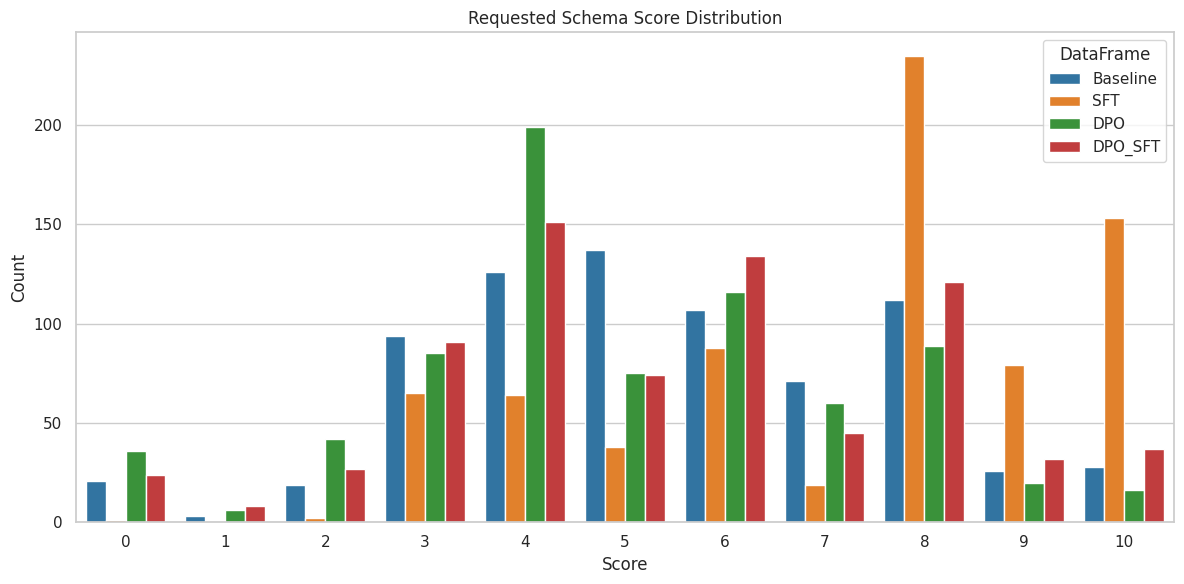

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plot_data = []

for model_name, df in zip(model_names, dfs):
    if 'schema_score' not in df.columns:
        df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

    capped_scores = df['schema_score'].round().clip(upper=10).astype(int)

    score_counts = capped_scores.value_counts().sort_index()

    for score, count in score_counts.items():
        plot_data.append({'Score': score, 'Count': count, 'DataFrame': model_name})

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='Score', y='Count', hue='DataFrame', palette='tab10')

plt.title('Requested Schema Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(0, 11))
plt.legend(title='DataFrame')
plt.tight_layout()
plt.show()

Distribution of each Schema

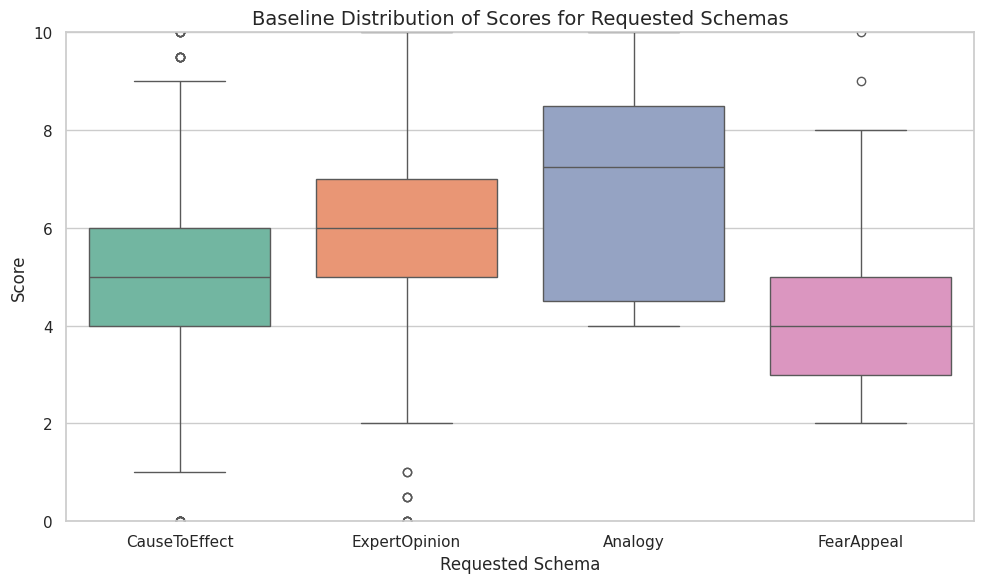

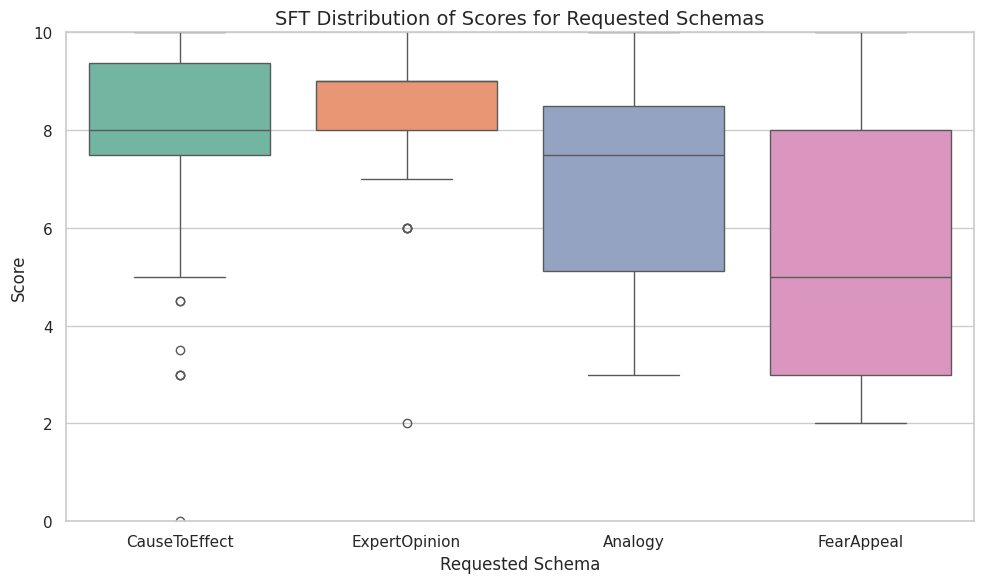

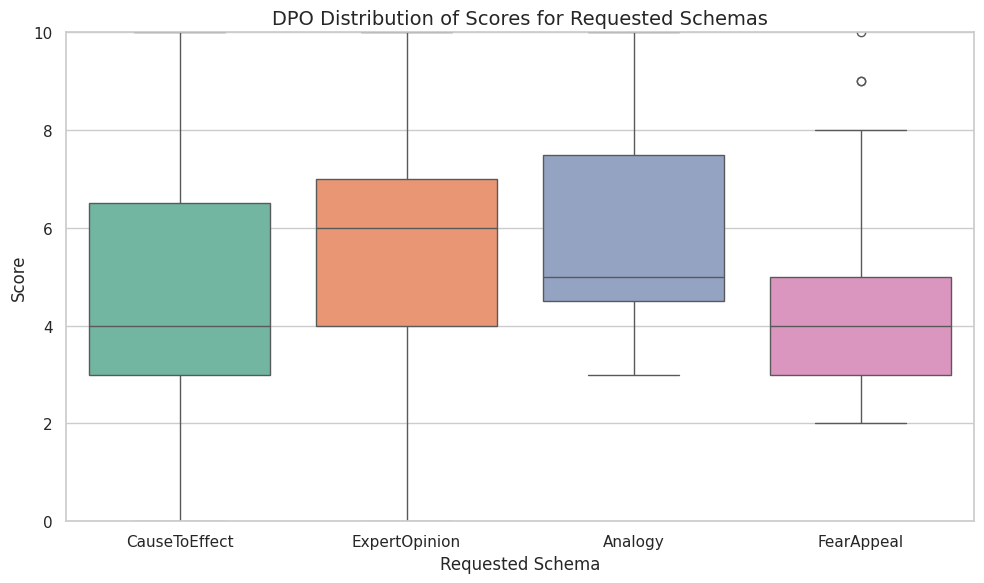

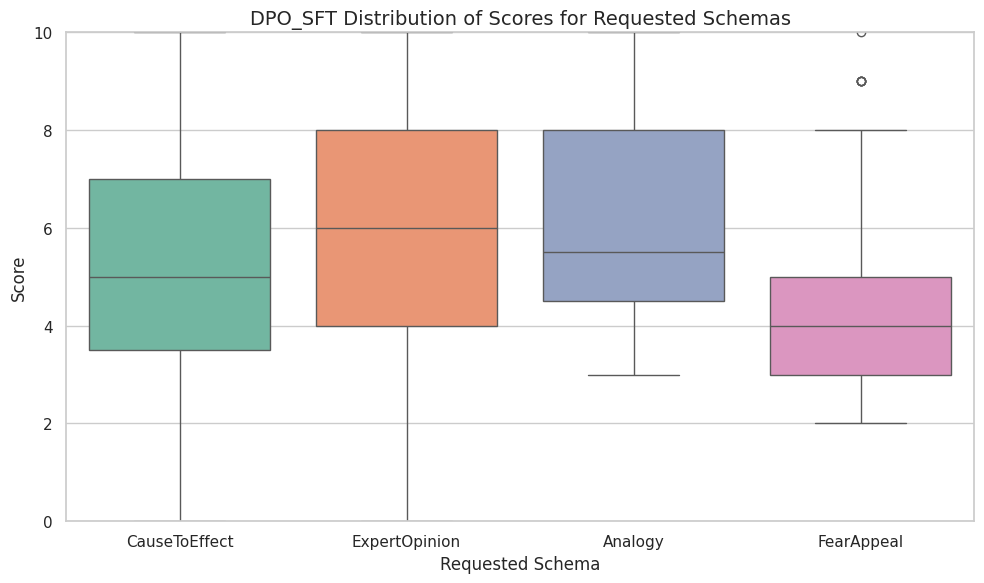

In [11]:
for model_name, df in zip(model_names, dfs):

  df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

  sns.set(style="whitegrid")

  plt.figure(figsize=(10, 6))
  sns.boxplot(x='schema', y='schema_score', data=df, hue='schema', palette='Set2', legend=False)

  plt.title(f'{model_name} Distribution of Scores for Requested Schemas', fontsize=14)
  plt.xlabel('Requested Schema')
  plt.ylabel('Score')
  plt.ylim(0, 10)
  plt.tight_layout()
  plt.show()

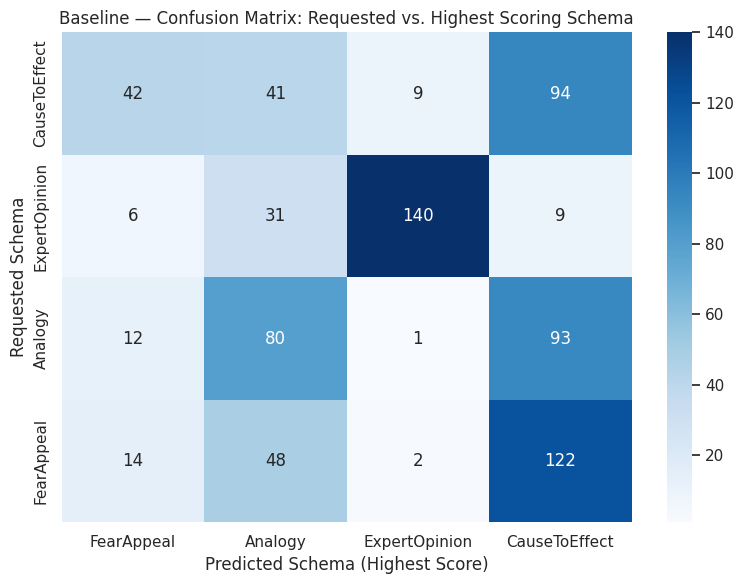

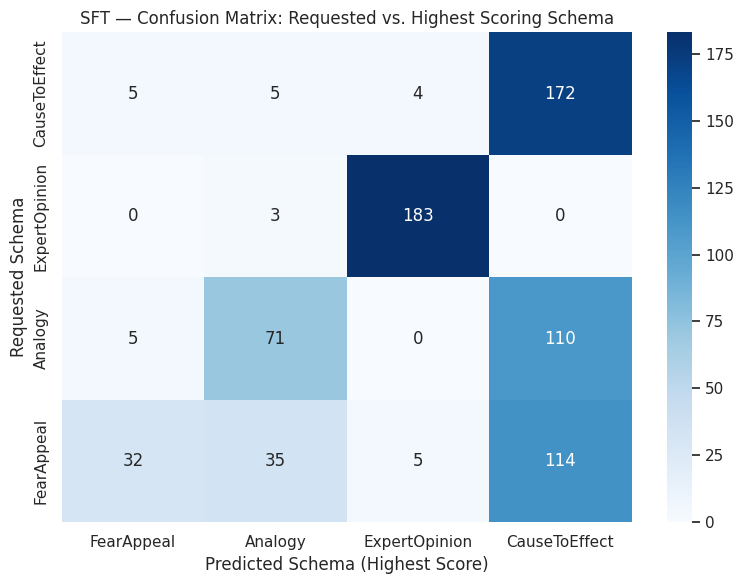

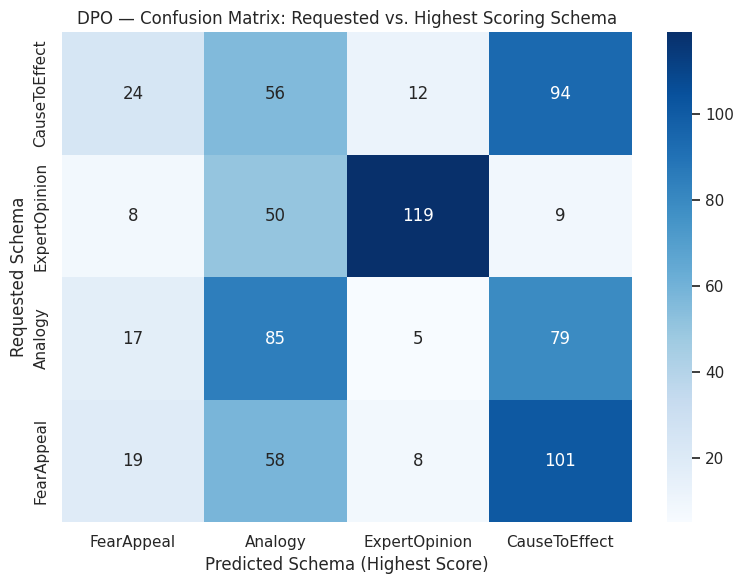

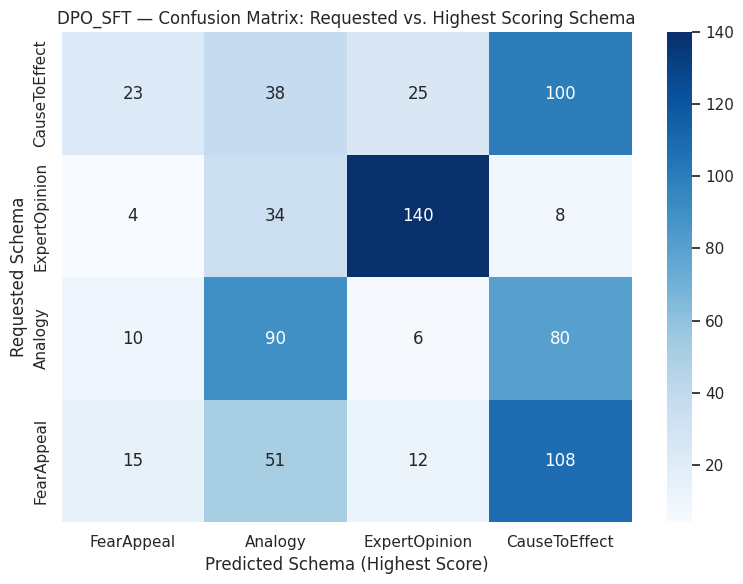

In [12]:
from sklearn.metrics import confusion_matrix

schemas = ['CauseToEffect', 'ExpertOpinion', 'Analogy', 'FearAppeal']
reversed_schemas = schemas[::-1]
model_names = ["Baseline", "SFT", "DPO", "DPO_SFT"]

for model_name, df in zip(model_names, dfs):
    df['predicted_schema'] = df[schemas].idxmax(axis=1)

    cm = confusion_matrix(df['schema'], df['predicted_schema'], labels=schemas)

    cm_reversed = cm[:, ::-1]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_reversed, annot=True, fmt='d', cmap='Blues',
                xticklabels=reversed_schemas, yticklabels=schemas)

    plt.xlabel('Predicted Schema (Highest Score)')
    plt.ylabel('Requested Schema')
    plt.title(f'{model_name} — Confusion Matrix: Requested vs. Highest Scoring Schema')
    plt.tight_layout()
    plt.show()


### Edge case Analysis

In [13]:
threshold = 7
rows = []
for i, df in enumerate(dfs):
    high_scores_count = (df[schemas] >= threshold).sum(axis=1)
    multiple_high_scores = (high_scores_count >= 2).sum()

    # Count rows with multiple scores >= 7 AND is_critical True
    multiple_high_and_critical = ((high_scores_count >= 2) & (df['is_critical'] == True)).sum()

    total = len(df)
    percent_multiple = (multiple_high_scores / total) * 100
    percent_multiple_and_critical = (multiple_high_and_critical / total) * 100

    rows.append({
        'Model': model_names[i],
        'Total Entries': total,
        'Entries with ≥2 Scores ≥7': multiple_high_scores,
        'Percentage': percent_multiple,
        'Entries with ≥2 Scores ≥7 AND Critical': multiple_high_and_critical,
        'Percentage (≥2 Scores ≥7 & Critical)': percent_multiple_and_critical
    })

summary_df = pd.DataFrame(rows)

# Style and display
styled = summary_df.style \
    .background_gradient(subset=['Entries with ≥2 Scores ≥7',
                                 'Percentage',
                                 'Entries with ≥2 Scores ≥7 AND Critical',
                                 'Percentage (≥2 Scores ≥7 & Critical)'], cmap='Greens') \
    .format({
        'Percentage': '{:.2f}%',
        'Percentage (≥2 Scores ≥7 & Critical)': '{:.2f}%'
    }) \
    .set_properties(subset=['Percentage', 'Percentage (≥2 Scores ≥7 & Critical)'], **{'text-align': 'right'}) \
    .set_caption("Entries with Multiple Scores ≥ 7 and Criticality per Model")

display(styled)

,Model,Total Entries,Entries with ≥2 Scores ≥7,Percentage,Entries with ≥2 Scores ≥7 AND Critical,Percentage (≥2 Scores ≥7 & Critical)
0,Baseline,744,77,10.35%,72,9.68%
1,SFT,744,216,29.03%,202,27.15%
2,DPO,744,59,7.93%,48,6.45%
3,DPO_SFT,744,86,11.56%,73,9.81%


In [14]:
rows = []
for i, df in enumerate(dfs):
    high_scores_count = (df[schemas] >= threshold).sum(axis=1)

    high_and_not_critical = ((high_scores_count >= 1) & (df['is_critical'] == False)).sum()

    total = len(df)
    percent = (high_and_not_critical / total) * 100

    rows.append({
        'Model': model_names[i],
        'Total Entries': total,
        'Entries with ≥1 Score ≥7 and NOT Critical': high_and_not_critical,
        'Percentage': percent
    })

summary_df = pd.DataFrame(rows)

styled = summary_df.style \
    .background_gradient(subset=['Entries with ≥1 Score ≥7 and NOT Critical', 'Percentage'], cmap='Reds') \
    .format({'Percentage': '{:.2f}%'}) \
    .set_properties(subset=['Percentage'], **{'text-align': 'right'}) \
    .set_caption("Entries with At Least One Score ≥ 7 and NOT Critical per Model")

display(styled)

,Model,Total Entries,Entries with ≥1 Score ≥7 and NOT Critical,Percentage
0,Baseline,744,137,18.41%
1,SFT,744,103,13.84%
2,DPO,744,118,15.86%
3,DPO_SFT,744,130,17.47%


In [15]:
all_schema_tables = {}

for model_name, df in zip(model_names, dfs):
    def next_highest_schema(row):
        requested = row['schema']
        requested_score = row[requested]
        others = [s for s in schemas if s != requested]
        next_best_score = row[others].max()
        next_best_schema = row[others].idxmax()
        return pd.Series({
            'next_highest_schema': next_best_schema,
            'next_highest_score': next_best_score,
            'requested_score': requested_score
        })

    df_next = df.apply(next_highest_schema, axis=1)
    df_combined = pd.concat([df, df_next], axis=1)

    summary = df_combined.groupby('schema').agg(
        avg_requested_score=('requested_score', 'mean'),
        avg_next_highest_score=('next_highest_score', 'mean'),
        most_common_next_schema=('next_highest_schema', lambda x: x.mode().iloc[0])
    ).reset_index()

    summary['Model'] = model_name
    all_schema_tables[model_name] = summary

for schema in schemas:
    rows = []
    for model_name in model_names:
        model_df = all_schema_tables[model_name]
        row = model_df[model_df['schema'] == schema]
        if not row.empty:
            rows.append(row)

    if rows:
        schema_table = pd.concat(rows, ignore_index=True)
        schema_table = schema_table[['Model', 'avg_requested_score', 'avg_next_highest_score', 'most_common_next_schema']]
        schema_table = schema_table.reset_index(drop=True)

        # Style
        styled = schema_table.style\
            .format({'avg_requested_score': '{:.2f}', 'avg_next_highest_score': '{:.2f}'})\
            .background_gradient(cmap="Greens", subset=['avg_requested_score', 'avg_next_highest_score'])

        print(f"\n### Schema: {schema}")
        display(styled)


### Schema: CauseToEffect


,Model,avg_requested_score,avg_next_highest_score,most_common_next_schema
0,Baseline,5.21,5.50,Analogy
1,SFT,7.81,5.37,FearAppeal
2,DPO,4.58,5.06,Analogy
3,DPO_SFT,5.17,5.34,FearAppeal



### Schema: ExpertOpinion


,Model,avg_requested_score,avg_next_highest_score,most_common_next_schema
0,Baseline,5.80,4.78,Analogy
1,SFT,8.72,5.28,Analogy
2,DPO,5.40,4.89,Analogy
3,DPO_SFT,6.08,4.78,Analogy



### Schema: Analogy


,Model,avg_requested_score,avg_next_highest_score,most_common_next_schema
0,Baseline,6.69,6.35,CauseToEffect
1,SFT,7.11,7.15,CauseToEffect
2,DPO,5.73,5.46,CauseToEffect
3,DPO_SFT,6.16,5.82,CauseToEffect



### Schema: FearAppeal


,Model,avg_requested_score,avg_next_highest_score,most_common_next_schema
0,Baseline,4.25,6.60,CauseToEffect
1,SFT,5.49,7.30,CauseToEffect
2,DPO,4.15,6.19,CauseToEffect
3,DPO_SFT,4.45,6.69,CauseToEffect
